In [1]:
import nltk
from keras.preprocessing.sequence import pad_sequences
from keras_preprocessing.text import Tokenizer
from nltk import WordNetLemmatizer, PorterStemmer, RegexpTokenizer
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
import pickle
import warnings
from sklearn.metrics import f1_score
from nltk.corpus import stopwords
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydotplus as pyd
import seaborn as sns
from gensim.models import KeyedVectors
from keras import backend as K
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Input, Flatten, Embedding, Conv1D, MaxPooling1D, Dropout, concatenate
from keras.models import Model, Sequential
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score
from keras.utils.np_utils import to_categorical
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
from gensim.models import Word2Vec
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [3]:
nltk.download('stopwords')
nltk.download('wordnet')

warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sichi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sichi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
# path = '/content/Insight_Stress_Analysis/data/'
path = '../data/'
train = pd.read_csv(path + 'dreaddit-train-processed.csv', encoding = "ISO-8859-1")
test = pd.read_csv(path + 'dreaddit-test-processed.csv', encoding = "ISO-8859-1")

In [5]:
features_train = train.drop(['id','subreddit','post_id','sentence_range','text','label','confidence','social_timestamp','social_karma','syntax_ari','processed_text'], 1)
features_test = test.drop(['id','subreddit','post_id','sentence_range','text','label','confidence','social_timestamp','social_karma','syntax_ari','processed_text'], 1)

print(features_train.columns)
features_len = len(features_train.columns)

Index(['Unnamed: 0', 'lex_liwc_WC', 'lex_liwc_Analytic', 'lex_liwc_Clout',
       'lex_liwc_Authentic', 'lex_liwc_Tone', 'lex_liwc_WPS',
       'lex_liwc_Sixltr', 'lex_liwc_Dic', 'lex_liwc_function',
       ...
       'lex_dal_min_pleasantness', 'lex_dal_min_activation',
       'lex_dal_min_imagery', 'lex_dal_avg_activation', 'lex_dal_avg_imagery',
       'lex_dal_avg_pleasantness', 'social_upvote_ratio',
       'social_num_comments', 'syntax_fk_grade', 'sentiment'],
      dtype='object', length=107)


In [6]:
def prepare_inputs(X_train, X_test):
    oe = OrdinalEncoder()
    oe.fit(X_train)
    X_train_enc = oe.transform(X_train)
    X_test_enc = oe.transform(X_test)
    return X_train_enc, X_test_enc

def prepare_targets(y_train, y_test):
    le = LabelEncoder()
    le.fit(y_train)
    y_train_enc = le.transform(y_train)
    y_test_enc = le.transform(y_test)
    return y_train_enc, y_test_enc

In [7]:
# # prepare input data
# X_train_enc, X_test_enc = prepare_inputs(features_train, features_test)
# # prepare output data
# y_train_enc, y_test_enc = prepare_targets(train["label"], test["label"])

In [8]:
w2v_model = KeyedVectors.load_word2vec_format('../GoogleNews-vectors-negative300.bin', binary=True)

In [9]:
t = Tokenizer()
#all_text = pd.concat(train['processed_text'],test['processed_text'])
t.fit_on_texts(train['processed_text'].values)
vocab_size = len(t.word_index) + 1
print(vocab_size)

8566


In [10]:
encoded_comments_train = t.texts_to_sequences(train['processed_text'])
encoded_comments_test = t.texts_to_sequences(test['processed_text'])

In [11]:
max_length = 512
padded_comments_train = pad_sequences(encoded_comments_train, maxlen=max_length, padding='post')
padded_comments_test = pad_sequences(encoded_comments_test, maxlen=max_length, padding='post')

In [12]:
y_train = train['label'].values
y_test = test['label'].values

y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

In [13]:
# create a weight matrix for words in training docs
embedding_matrix_w2v = np.zeros((vocab_size, 300))
for word, i in t.word_index.items():
    try:
        embedding_vector = w2v_model[word]
    except:
        embedding_vector = [0]*300

    if embedding_vector is not None:
        embedding_matrix_w2v[i] = embedding_vector

embedding_matrix_w2v.shape

(8566, 300)

In [14]:
reduce_lr = ReduceLROnPlateau(monitor='val_f1_m',
                              mode = 'max',
                              factor=0.5,
                              patience=5,
                              min_lr=0.0001,
                              verbose=10)

checkpoint = ModelCheckpoint("model_01.h5",
                               monitor="val_f1_m",
                               mode="max",
                               save_best_only = True,
                               verbose=1)

earlystop = EarlyStopping(monitor = 'val_f1_m',
                            mode="max",
                            min_delta = 0,
                            patience = 5,
                            verbose=1)

In [15]:
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

## Model 1: Baseline CNN

In [16]:
model = Sequential()
model.add(Input(shape=(512,), name='main_input'))
model.add(Embedding(vocab_size, 300, weights=[embedding_matrix_w2v], trainable=False))
model.add(Dropout(0.3))
model.add(Conv1D(filters=50, kernel_size=4, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=100, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu', name='fully_connected'))
model.add(Dense(2, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.0001), metrics=[get_f1])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 512, 300)          2569800   
                                                                 
 dropout (Dropout)           (None, 512, 300)          0         
                                                                 
 conv1d (Conv1D)             (None, 509, 50)           60050     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 254, 50)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 252, 100)          15100     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 126, 100)         0         
 1D)                                                    

In [17]:
h1 = model.fit(padded_comments_train, y_train,
               batch_size=64,
               epochs=50,
               verbose=1, callbacks=[ checkpoint, earlystop, reduce_lr],  #tensorboard
               validation_data=(padded_comments_test, y_test))

Epoch 1/50
45/45 [==============================] - 14s 300ms/step - loss: 0.6834 - get_f1: 0.5561 - val_loss: 0.6789 - val_get_f1: 0.5858 - lr: 1.0000e-04
Epoch 2/50
45/45 [==============================] - 13s 281ms/step - loss: 0.6552 - get_f1: 0.6269 - val_loss: 0.6560 - val_get_f1: 0.5999 - lr: 1.0000e-04
Epoch 3/50
45/45 [==============================] - 12s 275ms/step - loss: 0.6057 - get_f1: 0.6863 - val_loss: 0.6666 - val_get_f1: 0.6286 - lr: 1.0000e-04
Epoch 4/50
45/45 [==============================] - 14s 316ms/step - loss: 0.5581 - get_f1: 0.7141 - val_loss: 0.5908 - val_get_f1: 0.6969 - lr: 1.0000e-04
Epoch 5/50
45/45 [==============================] - 14s 301ms/step - loss: 0.5317 - get_f1: 0.7318 - val_loss: 0.5976 - val_get_f1: 0.6731 - lr: 1.0000e-04
Epoch 6/50
45/45 [==============================] - 13s 284ms/step - loss: 0.5101 - get_f1: 0.7512 - val_loss: 0.5630 - val_get_f1: 0.7153 - lr: 1.0000e-04
Epoch 7/50
45/45 [==============================] - 14s 309ms/st

45/45 [==============================] - 13s 298ms/step - loss: 0.3929 - get_f1: 0.8203 - val_loss: 0.5961 - val_get_f1: 0.7038 - lr: 1.0000e-04
Epoch 15/50
45/45 [==============================] - 14s 305ms/step - loss: 0.3855 - get_f1: 0.8257 - val_loss: 0.5663 - val_get_f1: 0.7218 - lr: 1.0000e-04
Epoch 16/50
45/45 [==============================] - 13s 294ms/step - loss: 0.3745 - get_f1: 0.8353 - val_loss: 0.5993 - val_get_f1: 0.6999 - lr: 1.0000e-04
Epoch 17/50
45/45 [==============================] - 13s 290ms/step - loss: 0.3588 - get_f1: 0.8456 - val_loss: 0.6537 - val_get_f1: 0.6843 - lr: 1.0000e-04
Epoch 18/50
45/45 [==============================] - 14s 302ms/step - loss: 0.3450 - get_f1: 0.8557 - val_loss: 0.5490 - val_get_f1: 0.7502 - lr: 1.0000e-04
Epoch 19/50
45/45 [==============================] - 13s 292ms/step - loss: 0.3360 - get_f1: 0.8602 - val_loss: 0.6447 - val_get_f1: 0.6960 - lr: 1.0000e-04
Epoch 20/50
45/45 [==============================] - 13s 291ms/step - 

45/45 [==============================] - 14s 306ms/step - loss: 0.2483 - get_f1: 0.8977 - val_loss: 0.6316 - val_get_f1: 0.7179 - lr: 1.0000e-04
Epoch 28/50
45/45 [==============================] - 13s 288ms/step - loss: 0.2394 - get_f1: 0.9174 - val_loss: 0.6236 - val_get_f1: 0.7335 - lr: 1.0000e-04
Epoch 29/50
45/45 [==============================] - 13s 299ms/step - loss: 0.2359 - get_f1: 0.9115 - val_loss: 0.6358 - val_get_f1: 0.7231 - lr: 1.0000e-04
Epoch 30/50
45/45 [==============================] - 13s 299ms/step - loss: 0.2157 - get_f1: 0.9223 - val_loss: 0.6700 - val_get_f1: 0.7153 - lr: 1.0000e-04
Epoch 31/50
45/45 [==============================] - 13s 289ms/step - loss: 0.2197 - get_f1: 0.9251 - val_loss: 0.6322 - val_get_f1: 0.7335 - lr: 1.0000e-04
Epoch 32/50
45/45 [==============================] - 14s 304ms/step - loss: 0.2036 - get_f1: 0.9278 - val_loss: 0.6543 - val_get_f1: 0.7270 - lr: 1.0000e-04
Epoch 33/50
45/45 [==============================] - 13s 294ms/step - 

45/45 [==============================] - 12s 266ms/step - loss: 0.1473 - get_f1: 0.9535 - val_loss: 0.7355 - val_get_f1: 0.7090 - lr: 1.0000e-04
Epoch 41/50
45/45 [==============================] - 13s 283ms/step - loss: 0.1382 - get_f1: 0.9577 - val_loss: 0.7324 - val_get_f1: 0.7179 - lr: 1.0000e-04
Epoch 42/50
45/45 [==============================] - 12s 266ms/step - loss: 0.1340 - get_f1: 0.9594 - val_loss: 0.7760 - val_get_f1: 0.7051 - lr: 1.0000e-04
Epoch 43/50
45/45 [==============================] - 12s 272ms/step - loss: 0.1260 - get_f1: 0.9615 - val_loss: 0.7396 - val_get_f1: 0.7153 - lr: 1.0000e-04
Epoch 44/50
45/45 [==============================] - 13s 297ms/step - loss: 0.1231 - get_f1: 0.9615 - val_loss: 0.7429 - val_get_f1: 0.7140 - lr: 1.0000e-04
Epoch 45/50
45/45 [==============================] - 12s 265ms/step - loss: 0.1092 - get_f1: 0.9716 - val_loss: 0.8321 - val_get_f1: 0.7025 - lr: 1.0000e-04
Epoch 46/50
45/45 [==============================] - 12s 275ms/step - 

In [18]:
score_1 = model.evaluate(padded_comments_test, y_test)
print(score_1)

23/23 [==============================] - 1s 28ms/step - loss: 0.8892 - get_f1: 0.6960
[0.8892291188240051, 0.6960226893424988]


[[184 162]
 [ 56 313]]


<AxesSubplot:>

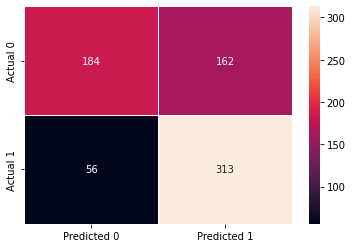

In [19]:
cnf_mat = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(model.predict(padded_comments_test), axis=1))

print(cnf_mat)
sns.heatmap(cnf_mat, annot=True, fmt='g', linewidths=.5, xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])

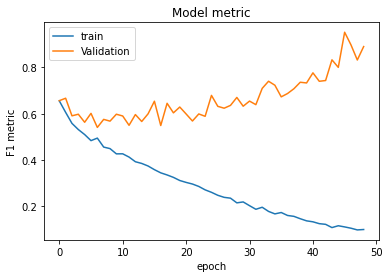

In [20]:
plt.plot(h1.history['loss'][1:])
plt.plot(h1.history['val_loss'][1:])
plt.title('Model metric')
plt.ylabel('F1 metric')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.savefig('CNN1_f1.png')
plt.show()

## Model 2: CNN + features

In [21]:
def df_to_dataset(dataframe, batch_size=32):
    ds = tf.data.Dataset.from_tensor_slices(dataframe)
    ds = ds.batch(batch_size)
    return ds

In [22]:
# batch_size = 64 #
# f_train = df_to_dataset(dict(features_train.copy()), batch_size=batch_size)
# f_test = df_to_dataset(dict(features_test.copy()), batch_size=batch_size)
# y_train = df_to_dataset(train["label"], batch_size=batch_size)
# y_test = df_to_dataset(test["label"], batch_size=batch_size)

In [23]:
# Defining the embedding layer

# model.add(Conv1D(filters=50, kernel_size=4, activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Conv1D(filters=100, kernel_size=3, activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Dense(2, activation='softmax'))

embedding_dim = 300
input1=Input(shape=(512,),name="main_input")

embedding_layer = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix_w2v], trainable=False)(input1)
conv1 = Conv1D(filters=50, kernel_size=4, activation='relu')(embedding_layer)
maxpool1 = MaxPooling1D(pool_size=2)(conv1)
conv2 = Conv1D(filters=100, kernel_size=3, activation='relu')(maxpool1)
maxpool2 = MaxPooling1D(pool_size=2)(conv2)
flatten = Flatten()(maxpool2)

cnn_output =  Model(inputs = input1,outputs = flatten)

input2=Input(shape=(features_len,))

merge = concatenate([cnn_output.output,input2])

reg_dense1 = Dense(64, activation='relu')(merge)
reg_dense2 = Dense(16, activation='relu')(reg_dense1)
output1 = Dense(2, activation='softmax')(reg_dense2)

clf_dense1 = Dense(64, activation='relu')(merge)
clf_dense2 = Dense(16, activation='relu')(clf_dense1)

output2 = Dense(2, activation='softmax')(clf_dense2)

model = Model(inputs=[input1,input2], outputs=[output1,output2])


In [24]:
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.0001), metrics=[get_f1])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 main_input (InputLayer)        [(None, 512)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 512, 300)     2569800     ['main_input[0][0]']             
                                                                                                  
 conv1d_2 (Conv1D)              (None, 509, 50)      60050       ['embedding_1[0][0]']            
                                                                                                  
 max_pooling1d_2 (MaxPooling1D)  (None, 254, 50)     0           ['conv1d_2[0][0]']               
                                                                                            

In [25]:
print(y_test.shape)
print(y_train.shape)

(715, 2)
(2838, 2)


In [26]:
h1 = model.fit([padded_comments_train, np.array(features_train.values)], y_train,
               batch_size=64,
               epochs=50,
               verbose=1, callbacks=[ checkpoint, earlystop, reduce_lr],  #tensorboard
               validation_data=([padded_comments_test, np.array(features_test.values)], y_test))

Epoch 1/50
45/45 [==============================] - 9s 183ms/step - loss: 4.5766 - dense_3_loss: 0.7448 - dense_6_loss: 3.8318 - dense_3_get_f1: 0.6100 - dense_6_get_f1: 0.5368 - val_loss: 1.3390 - val_dense_3_loss: 0.5828 - val_dense_6_loss: 0.7562 - val_dense_3_get_f1: 0.6605 - val_dense_6_get_f1: 0.6004 - lr: 1.0000e-04
Epoch 2/50
45/45 [==============================] - 8s 185ms/step - loss: 1.2424 - dense_3_loss: 0.5595 - dense_6_loss: 0.6829 - dense_3_get_f1: 0.7147 - dense_6_get_f1: 0.6370 - val_loss: 1.1165 - val_dense_3_loss: 0.5496 - val_dense_6_loss: 0.5669 - val_dense_3_get_f1: 0.7195 - val_dense_6_get_f1: 0.7351 - lr: 1.0000e-04
Epoch 3/50
45/45 [==============================] - 8s 181ms/step - loss: 1.1046 - dense_3_loss: 0.5402 - dense_6_loss: 0.5644 - dense_3_get_f1: 0.7315 - dense_6_get_f1: 0.7116 - val_loss: 1.0662 - val_dense_3_loss: 0.5263 - val_dense_6_loss: 0.5399 - val_dense_3_get_f1: 0.7286 - val_dense_6_get_f1: 0.7082 - lr: 1.0000e-04
Epoch 4/50
45/45 [=======

45/45 [==============================] - 8s 181ms/step - loss: 0.9389 - dense_3_loss: 0.4629 - dense_6_loss: 0.4760 - dense_3_get_f1: 0.7749 - dense_6_get_f1: 0.7627 - val_loss: 1.0259 - val_dense_3_loss: 0.5113 - val_dense_6_loss: 0.5146 - val_dense_3_get_f1: 0.7403 - val_dense_6_get_f1: 0.7455 - lr: 1.0000e-04
Epoch 9/50
45/45 [==============================] - 8s 178ms/step - loss: 0.9163 - dense_3_loss: 0.4511 - dense_6_loss: 0.4651 - dense_3_get_f1: 0.7790 - dense_6_get_f1: 0.7730 - val_loss: 1.0132 - val_dense_3_loss: 0.5058 - val_dense_6_loss: 0.5074 - val_dense_3_get_f1: 0.7301 - val_dense_6_get_f1: 0.7442 - lr: 1.0000e-04
Epoch 10/50
45/45 [==============================] - 8s 174ms/step - loss: 0.9024 - dense_3_loss: 0.4435 - dense_6_loss: 0.4589 - dense_3_get_f1: 0.7824 - dense_6_get_f1: 0.7724 - val_loss: 1.0164 - val_dense_3_loss: 0.5060 - val_dense_6_loss: 0.5104 - val_dense_3_get_f1: 0.7351 - val_dense_6_get_f1: 0.7364 - lr: 1.0000e-04
Epoch 11/50
45/45 [================

45/45 [==============================] - 8s 182ms/step - loss: 0.7188 - dense_3_loss: 0.3518 - dense_6_loss: 0.3670 - dense_3_get_f1: 0.8511 - dense_6_get_f1: 0.8390 - val_loss: 1.0735 - val_dense_3_loss: 0.5376 - val_dense_6_loss: 0.5358 - val_dense_3_get_f1: 0.7171 - val_dense_6_get_f1: 0.7390 - lr: 1.0000e-04
Epoch 17/50
45/45 [==============================] - 8s 185ms/step - loss: 0.6794 - dense_3_loss: 0.3346 - dense_6_loss: 0.3447 - dense_3_get_f1: 0.8664 - dense_6_get_f1: 0.8594 - val_loss: 1.0267 - val_dense_3_loss: 0.5072 - val_dense_6_loss: 0.5195 - val_dense_3_get_f1: 0.7507 - val_dense_6_get_f1: 0.7403 - lr: 1.0000e-04
Epoch 18/50
45/45 [==============================] - 8s 181ms/step - loss: 0.6521 - dense_3_loss: 0.3246 - dense_6_loss: 0.3275 - dense_3_get_f1: 0.8678 - dense_6_get_f1: 0.8629 - val_loss: 1.0317 - val_dense_3_loss: 0.5135 - val_dense_6_loss: 0.5182 - val_dense_3_get_f1: 0.7442 - val_dense_6_get_f1: 0.7288 - lr: 1.0000e-04
Epoch 19/50
45/45 [===============

Epoch 24/50
45/45 [==============================] - 8s 174ms/step - loss: 0.4450 - dense_3_loss: 0.2286 - dense_6_loss: 0.2164 - dense_3_get_f1: 0.9344 - dense_6_get_f1: 0.9396 - val_loss: 1.1002 - val_dense_3_loss: 0.5513 - val_dense_6_loss: 0.5489 - val_dense_3_get_f1: 0.7299 - val_dense_6_get_f1: 0.7364 - lr: 1.0000e-04
Epoch 25/50
45/45 [==============================] - 8s 177ms/step - loss: 0.4299 - dense_3_loss: 0.2214 - dense_6_loss: 0.2085 - dense_3_get_f1: 0.9361 - dense_6_get_f1: 0.9337 - val_loss: 1.1026 - val_dense_3_loss: 0.5513 - val_dense_6_loss: 0.5513 - val_dense_3_get_f1: 0.7405 - val_dense_6_get_f1: 0.7197 - lr: 1.0000e-04
Epoch 26/50
45/45 [==============================] - 8s 184ms/step - loss: 0.3962 - dense_3_loss: 0.2050 - dense_6_loss: 0.1913 - dense_3_get_f1: 0.9469 - dense_6_get_f1: 0.9406 - val_loss: 1.0985 - val_dense_3_loss: 0.5522 - val_dense_6_loss: 0.5463 - val_dense_3_get_f1: 0.7442 - val_dense_6_get_f1: 0.7377 - lr: 1.0000e-04
Epoch 27/50
45/45 [===

45/45 [==============================] - 8s 184ms/step - loss: 0.2853 - dense_3_loss: 0.1475 - dense_6_loss: 0.1378 - dense_3_get_f1: 0.9733 - dense_6_get_f1: 0.9705 - val_loss: 1.1912 - val_dense_3_loss: 0.5923 - val_dense_6_loss: 0.5989 - val_dense_3_get_f1: 0.7338 - val_dense_6_get_f1: 0.7299 - lr: 1.0000e-04
Epoch 32/50
45/45 [==============================] - 8s 182ms/step - loss: 0.2500 - dense_3_loss: 0.1321 - dense_6_loss: 0.1180 - dense_3_get_f1: 0.9774 - dense_6_get_f1: 0.9747 - val_loss: 1.1910 - val_dense_3_loss: 0.6028 - val_dense_6_loss: 0.5882 - val_dense_3_get_f1: 0.7377 - val_dense_6_get_f1: 0.7377 - lr: 1.0000e-04
Epoch 33/50
45/45 [==============================] - 8s 177ms/step - loss: 0.2281 - dense_3_loss: 0.1226 - dense_6_loss: 0.1055 - dense_3_get_f1: 0.9823 - dense_6_get_f1: 0.9861 - val_loss: 1.2350 - val_dense_3_loss: 0.6194 - val_dense_6_loss: 0.6156 - val_dense_3_get_f1: 0.7273 - val_dense_6_get_f1: 0.7286 - lr: 1.0000e-04
Epoch 34/50
45/45 [===============

45/45 [==============================] - 8s 177ms/step - loss: 0.1308 - dense_3_loss: 0.0674 - dense_6_loss: 0.0634 - dense_3_get_f1: 0.9945 - dense_6_get_f1: 0.9962 - val_loss: 1.3182 - val_dense_3_loss: 0.6668 - val_dense_6_loss: 0.6514 - val_dense_3_get_f1: 0.7197 - val_dense_6_get_f1: 0.7288 - lr: 1.0000e-04
Epoch 40/50
45/45 [==============================] - 8s 182ms/step - loss: 0.1197 - dense_3_loss: 0.0611 - dense_6_loss: 0.0585 - dense_3_get_f1: 0.9959 - dense_6_get_f1: 0.9969 - val_loss: 1.3455 - val_dense_3_loss: 0.6869 - val_dense_6_loss: 0.6587 - val_dense_3_get_f1: 0.7236 - val_dense_6_get_f1: 0.7301 - lr: 1.0000e-04
Epoch 41/50
45/45 [==============================] - 8s 185ms/step - loss: 0.1100 - dense_3_loss: 0.0556 - dense_6_loss: 0.0544 - dense_3_get_f1: 0.9979 - dense_6_get_f1: 0.9972 - val_loss: 1.3886 - val_dense_3_loss: 0.7133 - val_dense_6_loss: 0.6754 - val_dense_3_get_f1: 0.7353 - val_dense_6_get_f1: 0.7301 - lr: 1.0000e-04
Epoch 42/50
45/45 [===============

Epoch 47/50
45/45 [==============================] - 8s 180ms/step - loss: 0.0632 - dense_3_loss: 0.0306 - dense_6_loss: 0.0326 - dense_3_get_f1: 0.9997 - dense_6_get_f1: 0.9990 - val_loss: 1.5264 - val_dense_3_loss: 0.7918 - val_dense_6_loss: 0.7346 - val_dense_3_get_f1: 0.7301 - val_dense_6_get_f1: 0.7340 - lr: 1.0000e-04
Epoch 48/50
45/45 [==============================] - 8s 176ms/step - loss: 0.0624 - dense_3_loss: 0.0308 - dense_6_loss: 0.0316 - dense_3_get_f1: 0.9983 - dense_6_get_f1: 0.9990 - val_loss: 1.5221 - val_dense_3_loss: 0.7868 - val_dense_6_loss: 0.7353 - val_dense_3_get_f1: 0.7275 - val_dense_6_get_f1: 0.7301 - lr: 1.0000e-04
Epoch 49/50
45/45 [==============================] - 8s 177ms/step - loss: 0.0540 - dense_3_loss: 0.0258 - dense_6_loss: 0.0282 - dense_3_get_f1: 0.9997 - dense_6_get_f1: 0.9997 - val_loss: 1.5307 - val_dense_3_loss: 0.7937 - val_dense_6_loss: 0.7370 - val_dense_3_get_f1: 0.7262 - val_dense_6_get_f1: 0.7236 - lr: 1.0000e-04
Epoch 50/50
45/45 [===

In [27]:
score_1 = model.evaluate([padded_comments_test,features_test], y_test)
score_1
print('f1',score_1[3])

23/23 [==============================] - 1s 30ms/step - loss: 1.5614 - dense_3_loss: 0.8076 - dense_6_loss: 0.7538 - dense_3_get_f1: 0.7260 - dense_6_get_f1: 0.7315
f1 0.7260375022888184


In [32]:
print(features_test.shape)
print(y_test.shape)

(715, 107)
(715, 2)


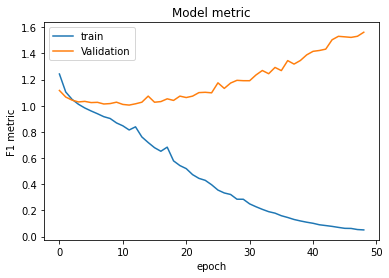

In [33]:
plt.plot(h1.history['loss'][1:])
plt.plot(h1.history['val_loss'][1:])
plt.title('Model metric')
plt.ylabel('F1 metric')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.savefig('CNN2_f1.png')
plt.show()